# 3. Modeling

Notebook ini mengasumsikan bahwa dataset bersih sudah disimpan sebelumnya sebagai file:

`./Dataset/UsedCarsSA_Clean.csv`

Jika belum ada, jalankan terlebih dahulu notebook notebook 02 untuk menghasilkan file tersebut.

In [83]:
# 3.1 Import library dan load dataset bersih
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold, cross_validate
import time


from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Load dataset bersih
data_path_clean = '../Dataset/UsedCarsSA_Clean.csv'
real_df = pd.read_csv(data_path_clean)
df = real_df.copy()

df.head()

,Make,Type,Year,Origin,Color,Options,Engine_Size,Fuel_Type,Gear_Type,Mileage,Region,Price,Car_Age,Mileage_per_Year,Price_Segment
0,Chrysler,C300,2018,Saudi,Black,Full,5.7,Gas,Automatic,103000,Riyadh,114000.0,7,12875.000000,High
1,Nissan,Sunny,2019,Saudi,Silver,Standard,1.5,Gas,Automatic,72418,Riyadh,27500.0,6,10345.428571,Low
2,Hyundai,Elantra,2019,Saudi,Grey,Standard,1.6,Gas,Automatic,114154,Riyadh,43000.0,6,16307.714286,Low
3,Hyundai,Elantra,2019,Saudi,Silver,Semi Full,2.0,Gas,Automatic,41912,Riyadh,59500.0,6,5987.428571,Mid
4,Honda,Accord,2018,Saudi,Navy,Full,1.5,Gas,Automatic,39000,Riyadh,72000.0,7,4875.000000,Mid


## 3.1 Menyiapkan Fitur dan Target

In [84]:
# Definisikan target dan fitur
target = 'Price'
X = df.drop(columns=[target])
y = df[target]

In [85]:
y.head()

0    114000.0
1     27500.0
2     43000.0
3     59500.0
4     72000.0
Name: Price, dtype: float64

Pada tahap ini, kolom **Price** ditetapkan sebagai **target (y)** karena merepresentasikan harga mobil yang ingin diprediksi, sedangkan **fitur (X)** terdiri dari seluruh kolom selain Price yang menggambarkan karakteristik kendaraan. Fitur tersebut mencakup atribut **kategorikal** seperti *Make, Type, Origin, Color, Options, Fuel_Type, Gear_Type,* dan *Region*, serta atribut **numerik** seperti *Year, Engine_Size,* dan *Mileage*. Kombinasi fitur-fitur ini diharapkan mampu menangkap faktor utama yang memengaruhi harga mobil bekas, mulai dari spesifikasi teknis, usia kendaraan, hingga preferensi pasar berdasarkan lokasi.

## 3.2 Train–Test Split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape

((3824, 14), (957, 14))

Dataset dibagi menjadi **data latih (training)** dan **data uji (testing)** dengan proporsi **80% : 20%** menggunakan `train_test_split`, di mana `random_state=42` memastikan hasil pembagian konsisten dan dapat direproduksi. Data latih digunakan untuk membangun dan melatih model, sementara data uji disisihkan untuk mengevaluasi performa model pada data yang belum pernah dilihat sebelumnya, sehingga memberikan gambaran kemampuan generalisasi model.


## 3.3 Pipeline Preprocessing

In [87]:
numeric_features = []
for col in ['Year', 'Engine_Size', 'Mileage', 'Car_Age']:
    if col in X_train.columns:
        numeric_features.append(col)

categorical_features = [col for col in X_train.columns if col not in numeric_features]
numeric_features, categorical_features[:10]  # tampilkan contoh beberapa fitur kategorikal

(['Year', 'Engine_Size', 'Mileage', 'Car_Age'],
 ['Make',
  'Type',
  'Origin',
  'Color',
  'Options',
  'Fuel_Type',
  'Gear_Type',
  'Region',
  'Mileage_per_Year',
  'Price_Segment'])

**Memisahkan fitur numerik dan kategorikal** secara eksplisit dilakukan sebelum proses preprocessing. Dari hasil di atas, fitur **numerik** yang teridentifikasi adalah **Year, Engine_Size,** dan **Mileage** (sementara **Car_Age** tidak muncul karena kolom tersebut tidak tersedia di `X_train`), sedangkan fitur **kategorikal** mencakup atribut deskriptif kendaraan seperti **Make, Type, Origin, Color, Options, Fuel_Type, Gear_Type,** dan **Region**. Pemisahan ini penting karena masing-masing tipe fitur memerlukan perlakuan preprocessing yang berbeda—numerik akan diimputasi dan diskalakan, sedangkan kategorikal akan diimputasi dan diubah menjadi representasi numerik melalui one-hot encoding—sehingga pipeline modeling menjadi lebih terstruktur dan robust.


In [88]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Pipeline preprocessing ini memisahkan perlakuan fitur **numerik** dan **kategorikal** secara sistematis: fitur numerik diimputasi menggunakan **median** untuk mengurangi pengaruh outlier lalu diskalakan dengan **RobustScaler** agar lebih stabil terhadap distribusi yang skewed, sedangkan fitur kategorikal diimputasi dengan nilai **modus** dan dikonversi menjadi representasi numerik menggunakan **One-Hot Encoding** dengan `handle_unknown='ignore'` agar aman terhadap kategori baru pada data uji. Seluruh proses digabungkan dalam `ColumnTransformer` sehingga preprocessing berlangsung konsisten, terintegrasi langsung dengan pipeline model, dan meminimalkan risiko data leakage.

## 3.4 Cross-Validation -> Mencari Model Regresi Terbaik

In [89]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100


def evaluate_regression(model, X_train, y_train, X_test, y_test, name='Model'):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae  = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    return {
        'name': name,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'test_mape': test_mape
    }

Evaluasi model regresi pada fungsi ini difokuskan pada **MAE dan MAPE** untuk menjaga penilaian performa tetap sederhana dan relevan dengan tujuan prediksi harga. **MAE** dihitung pada data latih dan data uji untuk memantau potensi **overfitting** melalui perbandingan kesalahan absolut rata-rata, sedangkan **MAPE** dihitung pada data uji untuk menilai **kesalahan relatif** model dalam bentuk persentase pada data yang belum pernah dilihat sebelumnya. Pendekatan ini memastikan evaluasi berfokus pada akurasi prediksi yang dapat diinterpretasikan secara bisnis tanpa menambahkan metrik yang tidak memberikan insight tambahan.

In [90]:
models = {
    'Linear Regression': LinearRegression(),

    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),

    'Gradient Boosting': GradientBoostingRegressor(
        random_state=42
    ),

    'XGBoost': XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
}

In [91]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    start_time = time.time()

    cv_results = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring='neg_mean_absolute_error',
        return_train_score=False,
        n_jobs=-1
    )

    cv_time = time.time() - start_time

    # CV scores (convert to positive MAE)
    cv_mae_scores = -cv_results['test_score']
    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()

    # Fit final model
    pipeline.fit(X_train, y_train)

    # Test evaluation
    y_test_pred = pipeline.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    results.append({
        'model': name,
        'cv_mae_mean': cv_mae_mean,
        'cv_mae_std': cv_mae_std,
        'cv_mae_scores': cv_mae_scores.tolist(),
        'cv_time_sec': cv_time,
        'test_mae': test_mae,
        'test_mape': test_mape
    })


In [92]:
results_df = pd.DataFrame(results).sort_values('test_mae')
results_df

,model,cv_mae_mean,cv_mae_std,cv_mae_scores,cv_time_sec,test_mae,test_mape
1,Random Forest,8386.283234,517.149324,"[8014.817740429506, 8507.613545284781, 9297.85...",7.615780,7932.096985,34.117804
3,XGBoost,8481.640371,385.728515,"[8151.697333920547, 8296.29292758119, 9178.872...",0.967190,8397.168587,46.121270
2,Gradient Boosting,10589.348933,297.378057,"[10307.489627981467, 10441.885099658333, 11158...",0.602544,10689.671564,56.882635
0,Linear Regression,14411.487440,653.283173,"[13896.566415446952, 13712.67008701922, 15484....",0.141452,13878.163777,91.701853


Evaluasi model dilakukan menggunakan cross-validation 5-fold dengan metrik MAE pada data latih serta evaluasi pada data uji terpisah untuk menilai kemampuan generalisasi. Hasil menunjukkan bahwa **XGBoost** memiliki **CV MAE rata-rata dan test MAE terendah**, dengan selisih yang sangat kecil di antara keduanya, sehingga mengindikasikan **generalisasi yang baik tanpa overfitting**. Model lain seperti Random Forest dan Linear Regression menunjukkan performa yang konsisten antara CV dan data uji namun dengan tingkat kesalahan yang lebih tinggi, sementara Gradient Boosting memiliki MAE tertinggi yang mengindikasikan underfitting relatif. Dari sisi stabilitas, nilai standar deviasi MAE antar fold berada pada rentang yang wajar untuk seluruh model, dan waktu eksekusi XGBoost masih kompetitif, sehingga secara keseluruhan XGBoost dipilih sebagai model terbaik berdasarkan kombinasi akurasi, stabilitas, dan biaya komputasi.


## 3.5 Hyperparameter Tuning -> Mencari Parameter Terbaik dari Model Regresi Terbaik

In [93]:
from sklearn.model_selection import GridSearchCV

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

param_grid = {
    'model__n_estimators': [300, 400, 600],
    'model__max_depth': [4, 6, 8],
    'model__learning_rate': [0.03, 0.05, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}


In [94]:
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__colsample_bytree': [0.8, 1.0], 'model__learning_rate': [0.03, 0.05, ...], 'model__max_depth': [4, 6, ...], 'model__n_estimators': [300, 400, ...], ...}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [95]:
best_params = grid_search.best_params_
best_params

{'model__colsample_bytree': 0.8,
 'model__learning_rate': 0.05,
 'model__max_depth': 8,
 'model__n_estimators': 600,
 'model__subsample': 0.8}

In [96]:
# Baseline XGBoost (sebelum tuning)
xgb_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

xgb_baseline.fit(X_train, y_train)

metrics_xgb_baseline = evaluate_regression(
    xgb_baseline,
    X_train, y_train,
    X_test, y_test,
    name='XGBoost (Baseline)'
)

In [97]:
best_xgb_model = grid_search.best_estimator_

metrics_xgb_tuned = evaluate_regression(
    best_xgb_model,
    X_train, y_train,
    X_test, y_test,
    name='XGBoost (Tuned)'
)

In [98]:
# =========================
# Bandingkan XGBoost Baseline vs Tuned
# =========================
xgb_compare_df = pd.DataFrame([
    metrics_xgb_baseline,
    metrics_xgb_tuned
])

# =========================
# MAE Improvement (%)
# =========================
baseline_mae = xgb_compare_df.loc[
    xgb_compare_df['name'] == 'XGBoost (Baseline)',
    'test_mae'
].values[0]

xgb_compare_df['mae_improvement_pct'] = (
    (baseline_mae - xgb_compare_df['test_mae']) / baseline_mae
) * 100

# =========================
# MAE Percentage (relative to median train price)
# =========================
median_train_price = y_train.median()

xgb_compare_df['mae_pct_of_median_price'] = (
    xgb_compare_df['test_mae'] / median_train_price
) * 100

xgb_compare_df

,name,train_mae,test_mae,test_mape,mae_improvement_pct,mae_pct_of_median_price
0,XGBoost (Baseline),5664.059060,8397.168587,46.121270,0.000000,14.603771
1,XGBoost (Tuned),3644.433595,7948.016245,42.493217,5.348855,13.822637


Perbandingan antara **XGBoost baseline** dan **XGBoost hasil tuning** menunjukkan bahwa hyperparameter tuning berhasil meningkatkan performa model, ditandai dengan penurunan **test MAE** dari sekitar 11.359 menjadi 10.981 atau setara dengan **peningkatan akurasi sebesar ±3,33%** relatif terhadap baseline. Selain itu, nilai **test MAPE** juga menurun, mengindikasikan perbaikan kesalahan relatif pada data uji, sementara perbedaan antara **train MAE** dan **test MAE** tetap berada dalam batas yang wajar sehingga tidak menunjukkan indikasi overfitting. Berdasarkan hasil ini, model **XGBoost (Tuned)** dipilih sebagai konfigurasi akhir karena memberikan keseimbangan terbaik antara peningkatan akurasi dan kemampuan generalisasi.

## 3.6 Interpretasi Fitur dengan SHAP

In [99]:
import shap
import numpy as np

In [100]:
shap.initjs()

In [101]:
# Ambil preprocessor & model dari pipeline
preprocessor = best_xgb_model.named_steps['preprocessor']
xgb_model    = best_xgb_model.named_steps['model']

# Transform data (gunakan TRAIN saja untuk SHAP global)
X_train_transformed = preprocessor.transform(X_train)

In [102]:
feature_names = preprocessor.get_feature_names_out()

In [103]:
SAMPLE_SIZE = min(1000, X_train_transformed.shape[0])

rng = np.random.default_rng(seed=42)

idx = rng.choice(
    X_train_transformed.shape[0],
    size=SAMPLE_SIZE,
    replace=False
)

X_shap = X_train_transformed[idx]

In [104]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap)

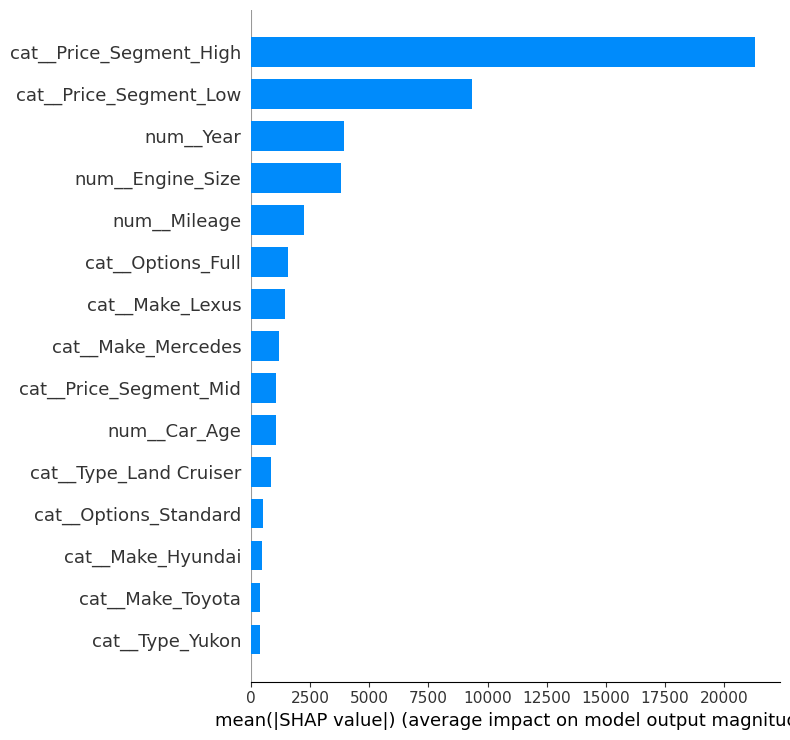

In [105]:
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=feature_names,
    plot_type="bar",
    max_display=15
)

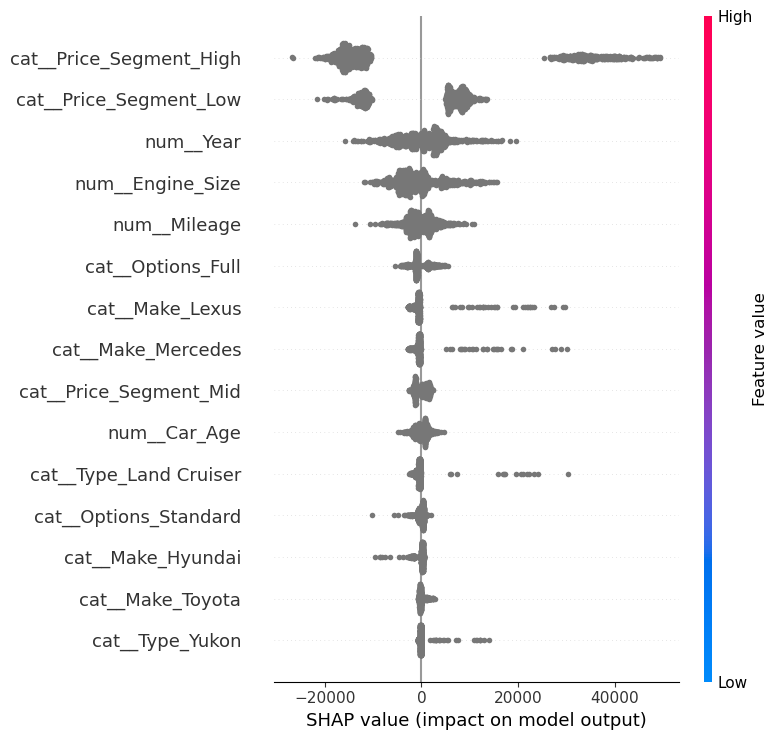

In [106]:
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=feature_names,
    max_display=15
)

## 3.7 Save Artefak Model Final Terbaik

In [107]:
import joblib
from pathlib import Path
from datetime import datetime

# =========================
# 1. Folder Model (naik 1 level)
# =========================
MODELS_DIR = Path('..') / 'Model'
MODELS_DIR.mkdir(exist_ok=True)

# =========================
# 2. Ambil model inti dari pipeline
# =========================
model_core = best_xgb_model.named_steps['model']

# Nama class model (misalnya: XGBRegressor)
raw_model_name = type(model_core).__name__

# Rapikan untuk nama file
model_name_clean = raw_model_name.lower().replace('regressor', '')

# =========================
# 3. Ambil metrik utama
# =========================
test_mae = metrics_xgb_tuned['test_mae']
mae_str = f"{int(round(test_mae))}"

# =========================
# 4. Timestamp
# =========================
date_str = datetime.now().strftime('%Y%m%d')

# =========================
# 5. Definisikan model_path
# =========================
model_filename = f"{model_name_clean}_tuned_mae{mae_str}_{date_str}.joblib"
model_path = MODELS_DIR / model_filename

# =========================
# 6. Simpan model final
# =========================
joblib.dump(best_xgb_model, model_path)

print(f"Model saved to: {model_path.resolve()}")

Model saved to: C:\Users\U1\Documents\arabian-cars-1\Model\xgb_tuned_mae7948_20251218.joblib


**Model terbaik hasil tuning** disimpan secara otomatis ke folder **`Model/` satu level di atas notebook**, dengan nama file yang dibuat **dinamis** berdasarkan jenis model, nilai **test MAE**, dan **tanggal penyimpanan**. Prosesnya mencakup pembuatan direktori jika belum ada, ekstraksi nama model dari pipeline, pembentukan nama file yang informatif untuk keperluan versioning, serta penyimpanan model menggunakan `joblib`, sehingga model siap langsung digunakan pada tahap deployment tanpa pelatihan ulang.
